In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

import matplotlib.pyplot as plt

In [2]:
# Problem parameters
N = 5  # Number of PEVGs
C = 99  # Grid capacity (MWh)
b_n = np.random.uniform(35, 65, N)  # Battery capacities
s_n = np.random.uniform(1, 2, N)    # Satisfaction parameters

In [3]:
# Define the multi-objective problem
class EVChargingProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=N + 1,  # p + x_1, x_2, ..., x_N
            n_obj=2,       # Two objectives: SG revenue and PEVG utility
            n_constr=1,    # One constraint: sum(x_n) <= C
            xl=np.array([17] + [0] * N),  # Lower bounds: p >= 0, x_n >= 0
            xu=np.array([50] + [C] * N)  # Upper bounds: p <= 50, x_n <= C
        )

    def _evaluate(self, X, out, *args, **kwargs):
        p = X[0]  # Price
        x = X[1:]  # Demands

        # Objective 1: SG revenue (maximize)
        f1 = p * np.sum(x)

        # Objective 2: PEVG total utility (maximize)
        f2 = np.sum(b_n * x - 0.5 * s_n * x**2 - p * x)

        # Constraint: sum(x_n) <= C (g(x) <= 0)
        g1 = np.sum(x) - C

        # U-NSGA-III minimizes, so negate objectives to maximize
        out["F"] = [-f1, -f2]
        out["G"] = [g1]

In [4]:
# Generate reference directions for 2 objectives
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)  # 91 points for 2 objectives

In [13]:
class SavePopulationCallback:
    def __init__(self):
        self.pop_history = []

    def notify(self, algorithm):
        self.pop_history.append(algorithm.pop.copy())

callback = SavePopulationCallback()

In [5]:
# Initialize U-NSGA-III algorithm
algorithm = UNSGA3(
    ref_dirs=ref_dirs,
    pop_size=200,  # Population size
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [6]:
# Define the problem
problem = EVChargingProblem()

In [15]:
# Run optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', 200),  # Number of generations
    seed=1,
    verbose=False,
    # callback=callback
)

In [16]:
X = res.X

In [19]:
F = -res.F

In [8]:
# Extract final population (all 100 solutions)
# final_pop = callback.pop_history[-1]  # Last generation
# X = np.array([ind.X for ind in final_pop])  # All decision variables
# F = np.array([ind.F for ind in final_pop])  # All objective values
# F = -F  # Convert back to maximized form

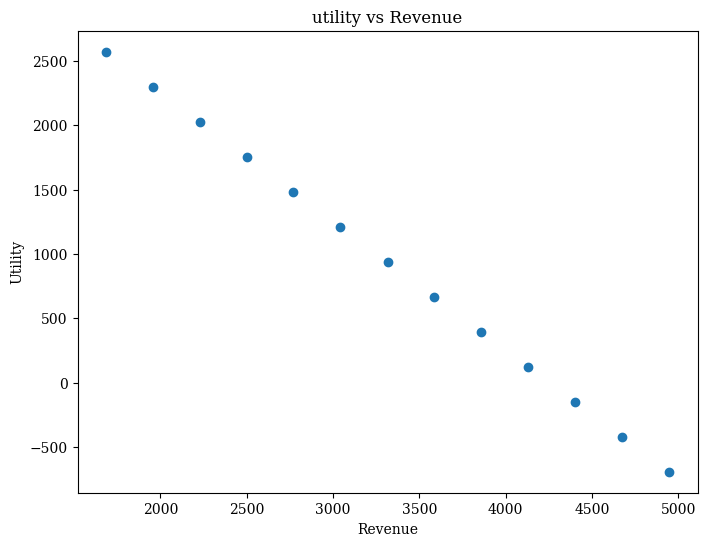

In [20]:
plot = Scatter()
plot.add(F, label="Pareto Front")
plot.show()
plt.xlabel("Revenue")
plt.ylabel("Utility")
plt.title("utility vs Revenue")
plt.show()

In [22]:

# # Print solutions
# print("Pareto-optimal solutions (Top 5):")
# for i in range(min(5, len(X))):
#     p = X[i][0]
#     x = X[i][1:]
#     sg_revenue = F[i][0]
#     pevg_utility = F[i][1]
#     total_demand = np.sum(x)
#     print(f"Solution {i+1}:")
#     print(f"  Price (p) = {p:.2f} USD/MWh")
#     print(f"  Demands (x_n) = {x}")
#     print(f"  SG Revenue = {sg_revenue:.2f}")
#     print(f"  PEVG Total Utility = {pevg_utility:.2f}")
#     print(f"  Total Demand = {total_demand:.2f} MWh (Constraint: <= {C})")
#     print()

In [21]:
# # Post-process to approximate GSE
# # GSE: p* = min(b_n - s_n x_n^*)
# print("GSE Approximations (Top 5):")
# for i in range(min(5, len(X))):
#     x = X[i][1:]
#     p_star = np.min(b_n - s_n * x)
#     sg_revenue_star = p_star * np.sum(x)
#     pevg_utility_star = np.sum(b_n * x - 0.5 * s_n * x**2 - p_star * x)
#     if sg_revenue_star >= 0 and pevg_utility_star >= 0:  # Ensure feasible
#         print(f"Solution {i+1}:")
#         print(f"  Adjusted Price (p*) = {p_star:.2f} USD/MWh")
#         print(f"  SG Revenue = {sg_revenue_star:.2f}")
#         print(f"  PEVG Total Utility = {pevg_utility_star:.2f}")
#         print()